In [1]:
import os
import re
from rmgpy.rmg.model import CoreEdgeReactionModel
from rmgpy.chemkin import loadChemkinFile
from rmgpy.molecule.draw import MoleculeDrawer
from rmgpy.chemkin import getSpeciesIdentifier
from rmgpy.rmg.output import OutputError
from extractInfoFromckcsv import getConcentrationDictFromCKCSV, getROPFromCKCSV
from pychemkin.chemkin import getTotalMoles

import numpy as np
import pandas as pd
from utilities.wikiMagics import JinjaMagics
from IPython.core.magic import register_cell_magic
ip = get_ipython()
ip.register_magics(JinjaMagics)

In [2]:
# chemkin model name
mech = 'pdd_scratch_add18'

In [3]:
path = os.path.abspath('../')
mechPath = path + '/data/' + mech
chemkinPath= mechPath + '/chem.inp'
dictionaryPath = mechPath + '/species_dictionary.txt'

model = CoreEdgeReactionModel()
model.core.species, model.core.reactions = loadChemkinFile(chemkinPath,dictionaryPath)

# generate paris for each reaction for later flux analysis
for rxn in model.core.reactions:
    if not rxn.pairs: rxn.generatePairs()

#generate species images
speciesPath = mechPath + '/species/'
if not os.path.isdir(speciesPath):
    os.makedirs(speciesPath)

species = model.core.species[:]
re_index_search = re.compile(r'\((\d+)\)$').search
for spec in species:
    match = re_index_search(spec.label)
    if match:
        spec.index = int(match.group(0)[1:-1])
        spec.label = spec.label[0:match.start()]
    # Draw molecules if necessary
    fstr = os.path.join(mechPath, 'species', '{0}.png'.format(spec))
    if not os.path.exists(fstr):
        try:
            MoleculeDrawer().draw(spec.molecule[0], 'png', fstr)
        except IndexError:
            raise OutputError("{0} species could not be drawn!".format(getSpeciesIdentifier(spec)))

In [4]:
ckcsvPath= mechPath + '/CKSoln.ckcsv'
firstColDict, spc_mf_dict = getConcentrationDictFromCKCSV(ckcsvPath)

_, spc_total_rop_dict, spc_rop_dict = getROPFromCKCSV(ckcsvPath)

totalMoles = getTotalMoles(ckcsvPath)[0]

In [5]:
# Give a reactant and conversion point for investigation
rxt = 'C18H30(3)'
# conv_investigated = 0.2
time_investigated = 1 #hr

# choose a spc for its ROP analysis
spc = 'C18H30(3)'# Toluene(3) or C8H8(9)

In [6]:
# get the top 20 important reactions for spc's rop at conv_investigated
initial_rxt_moles = spc_mf_dict[rxt][0]*totalMoles[0]

# idx = (numpy.abs(spc_mf_dict[rxt]*totalMoles-initial_rxt_moles*(1-conv_investigated))).argmin()
idx = (np.abs(firstColDict['Time_(sec)']-time_investigated*3600)).argmin()

spc_rxn_flux_sorted = sorted(spc_rop_dict[spc],key=lambda tup: -abs(tup[1][idx]))

top_num = 10
display_top_num = min(top_num, len(spc_rxn_flux_sorted))

top_rxnNum_list = []
top_flux_list = []
top_reactions = []

for i in range(display_top_num):
    header = spc_rxn_flux_sorted[i][0]
    rxnNum = int(header.split("#")[1].split('_')[0])
    flux = spc_rxn_flux_sorted[i][1][idx]
    top_rxnNum_list.append(rxnNum)
    top_flux_list.append(flux)
    top_reactions.append(model.core.reactions[rxnNum-1])

reactions = top_reactions

In [7]:
%%jinja html
rop_rxn.html

In [8]:
spc_df_dict = {}
for spc_str in spc_rop_dict:
    rxn_num_list = []
    pair_ptner_list = []
    family_list = []
    flux_array_list = []
    for entr in spc_rop_dict[spc_str]:
        desc = entr[0]
        flux_array = entr[1]
        rxn_num = desc.split('_')[0].split('#')[1]

        rxn = model.core.reactions[int(rxn_num)-1]
        pairs = rxn.pairs
        count = 0
        for pair in pairs:
            for i, pair_spc in enumerate(pair):
                if getSpeciesIdentifier(pair_spc) == spc_str:
                    count += 1
                    pair_ptner_list.append(pair[1-i])
                    rxn_num_list.append(rxn_num)
                    family_list.append(rxn.family)
                    flux_array_list.append(flux_array)
                    if count == 2:
                        flux_array_list[-1] = flux_array/2
                        flux_array_list[-2] = flux_array/2
    # create dataframe
    df_dict = {'rxn_num': rxn_num_list, 'pair_partner':pair_ptner_list,
              'family': family_list, 'flux_array':flux_array_list}
    df = pd.DataFrame(df_dict)
    spc_df_dict[spc_str] = df

In [9]:
pdd_df = spc_df_dict["C18H30(3)"]

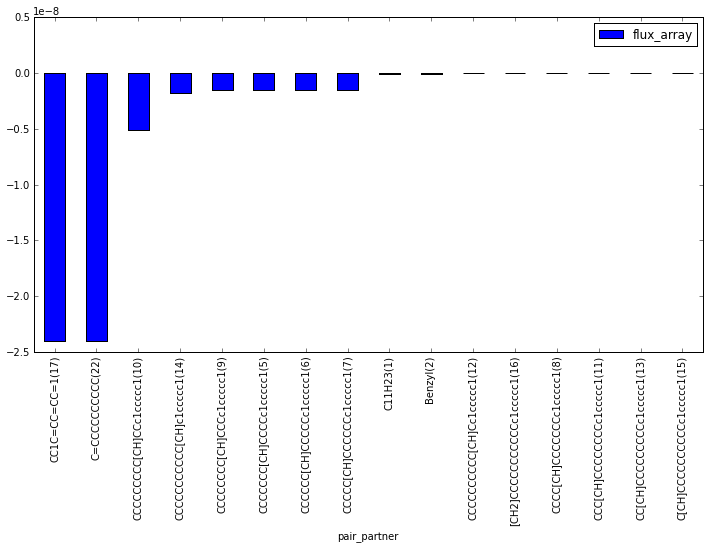

In [10]:
%matplotlib inline
g = pdd_df[['pair_partner','flux_array']].groupby('pair_partner')

g_refined = g.agg({"flux_array": lambda x: list(x.sum())[idx]}).sort_values(by=['flux_array'])
g_refined.plot(kind='bar', figsize=(12, 6))

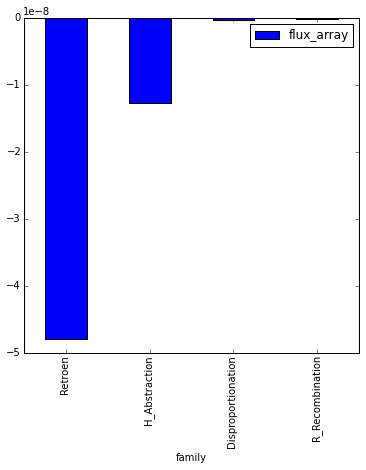

In [11]:
g = pdd_df[['family','flux_array']].groupby('family')

g_refined = g.agg({"flux_array": lambda x: list(x.sum())[idx]}).sort_values(by=['flux_array'])
g_refined.plot(kind='bar', figsize=(6, 6))

## Next step

- beautify the codes 